In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# XGBoost - Optimización con Grid Search
## Predicción de Características de Vuelo en Planeador

**Objetivo:** XGBoost optimizado con Grid Search directo

## 1. Setup

In [6]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from time import time

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

sys.path.append('../01_Preprocesamiento')
from eda_functions import configurar_visualizacion
from modelo_utils import preparar_datos, evaluar_modelo

warnings.filterwarnings('ignore')
configurar_visualizacion()
np.random.seed(42)

## 2. Cargar Datos

In [7]:
X_dev_simple = pd.read_csv('../data/split/X_dev_simple.csv', index_col=0)
X_test_simple = pd.read_csv('../data/split/X_test_simple.csv', index_col=0)
X_dev_full = pd.read_csv('../data/split/X_dev_full.csv', index_col=0)
X_test_full = pd.read_csv('../data/split/X_test_full.csv', index_col=0)
y_dev = pd.read_csv('../data/split/y_dev.csv', index_col=0)
y_test = pd.read_csv('../data/split/y_test.csv', index_col=0)

targets_reg = [
    'altura_max_m', 'ganancia_altura_m', 'duracion_min', 'distancia_km', 'velocidad_promedio_kmh',
    'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min','tasa_ascenso_mean_ms'
]

---
# PARTE 1: Grid Search Exhaustivo

Búsqueda DIRECTA de mejores hiperparámetros

## 4. Grid de Hiperparámetros

**Rango amplio para explorar:**
- Incluye valores conservadores (max_depth=2) y agresivos (max_depth=6)
- CV seleccionará automáticamente los que NO overfittean

In [ ]:
# Grid de hiperparámetros (amplio, CV selecciona mejores)
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_child_weight': [1, 3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0]
}

print("Grid de hiperparámetros:")
for param, values in param_grid.items():
    print(f"  {param:20s}: {values}")

total_comb = (len(param_grid['max_depth']) * 
              len(param_grid['min_child_weight']) * 
              len(param_grid['learning_rate']) * 
              len(param_grid['n_estimators']) * 
              len(param_grid['subsample']) * 
              len(param_grid['colsample_bytree']))

print(f"\nTotal combinaciones: {total_comb:,}")
print(f"Con CV=5: {total_comb * 5:,} fits por target")

Grid de hiperparámetros:
  max_depth           : [2, 3, 4, 5, 6]
  min_child_weight    : [1, 3, 5, 7, 10]
  learning_rate       : [0.01, 0.05, 0.1, 0.2]
  n_estimators        : [50, 100, 150, 200]
  subsample           : [0.6, 0.7, 0.8, 1.0]
  colsample_bytree    : [0.6, 0.7, 0.8, 1.0]

Total combinaciones: 6,400
Con CV=5: 32,000 fits por target

⚠️  Esto tomará tiempo (~10-15 min por target).


## 5. Grid Search - Features SIMPLES

In [ ]:
# Archivo pickle para guardar resultados
pkl_file_simple = '../data/processed/xgb_simple_models.pkl'

# Intentar cargar resultados previos
if os.path.exists(pkl_file_simple):
    print(" Cargando resultados previos (Grid Search ya ejecutado)")
    
    with open(pkl_file_simple, 'rb') as f:
        saved_data = pickle.load(f)
        resultados_xgb_simple = saved_data['resultados']
        mejores_modelos_simple = saved_data['modelos']
    
    df_xgb_simple = pd.DataFrame(resultados_xgb_simple)
    
    print(f"\n Cargados {len(resultados_xgb_simple)} targets")
    print(f"Gap promedio: {df_xgb_simple['Gap'].mean():.4f}")
    print(f"R² promedio Test: {df_xgb_simple['Test_R2'].mean():.4f}")
    print("\nSi querés re-entrenar, eliminá el archivo:")
    print(f"  {pkl_file_simple}")

else:


    resultados_xgb_simple = []
    mejores_modelos_simple = {}

    print("GRID SEARCH - XGBoost FEATURES SIMPLES")

    for target in targets_reg:
        print(f"\n{target}:")
        inicio = time()
        
        # Base model
        xgb_base = XGBRegressor(
            random_state=42,
            n_jobs=-1
        )
        
        # Grid Search con CV
        grid = GridSearchCV(
            xgb_base,
            param_grid,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        
        grid.fit(X_dev_simple, y_dev[target])
        
        # Mejor modelo (seleccionado por CV)
        best_xgb = grid.best_estimator_
        mejores_modelos_simple[target] = best_xgb
        
        # Predicciones
        y_pred_dev = best_xgb.predict(X_dev_simple)
        y_pred_test = best_xgb.predict(X_test_simple)
        
        r2_cv = grid.best_score_
        r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
        r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
        gap = r2_cv - r2_test
        
        resultados_xgb_simple.append({
            'target': target,
            'features': 'simple',
            'max_depth': grid.best_params_['max_depth'],
            'min_child_weight': grid.best_params_['min_child_weight'],
            'learning_rate': grid.best_params_['learning_rate'],
            'n_estimators': grid.best_params_['n_estimators'],
            'subsample': grid.best_params_['subsample'],
            'colsample_bytree': grid.best_params_['colsample_bytree'],
            'CV_R2': r2_cv,
            'Dev_R2': r2_dev,
            'Test_R2': max(0, r2_test),
            'Gap': gap
        })
        
        tiempo = time() - inicio
        overfit_signal = "OVERFITTING" if gap > 0.15 else "OK"
        
        print(f"  Mejores params (seleccionados por CV):")
        print(f"    max_depth={grid.best_params_['max_depth']}, "
            f"min_child_weight={grid.best_params_['min_child_weight']}")
        print(f"    lr={grid.best_params_['learning_rate']}, "
            f"n_est={grid.best_params_['n_estimators']}")
        print(f"    subsample={grid.best_params_['subsample']}, "
            f"colsample={grid.best_params_['colsample_bytree']}")
        print(f"  CV={r2_cv:.4f}, Test={max(0, r2_test):.4f}, "
            f"Gap={gap:.4f} {overfit_signal}")
        print(f"  Tiempo: {tiempo:.1f}s")

    df_xgb_simple = pd.DataFrame(resultados_xgb_simple)
    # GUARDAR con pickle
    with open(pkl_file_simple, 'wb') as f:
        pickle.dump({
            'resultados': resultados_xgb_simple,
            'modelos': mejores_modelos_simple
        }, f)
    
    print(f" Resultados guardados en: {pkl_file_simple}")
    print(f"Gap promedio: {df_xgb_simple['Gap'].mean():.4f}")
    print(f"R² promedio Test: {df_xgb_simple['Test_R2'].mean():.4f}")

# Guardar también CSV (para análisis)
df_xgb_simple.to_csv('../data/processed/xgb_simple.csv', index=False)

GRID SEARCH - XGBoost FEATURES SIMPLES

altura_max_m:
  Mejores params (seleccionados por CV):
    max_depth=6, min_child_weight=3
    lr=0.1, n_est=100
    subsample=0.7, colsample=0.7
  CV=0.6393, Test=0.7227, Gap=-0.0834 ✓ OK
  Tiempo: 549.4s

ganancia_altura_m:
  Mejores params (seleccionados por CV):
    max_depth=4, min_child_weight=1
    lr=0.2, n_est=100
    subsample=0.7, colsample=1.0
  CV=0.6096, Test=0.6246, Gap=-0.0150 ✓ OK
  Tiempo: 552.4s

duracion_min:
  Mejores params (seleccionados por CV):
    max_depth=4, min_child_weight=1
    lr=0.05, n_est=150
    subsample=0.6, colsample=0.8
  CV=0.5934, Test=0.7719, Gap=-0.1785 ✓ OK
  Tiempo: 569.5s

distancia_km:
  Mejores params (seleccionados por CV):
    max_depth=4, min_child_weight=1
    lr=0.05, n_est=200
    subsample=0.6, colsample=0.8
  CV=0.6047, Test=0.8172, Gap=-0.2125 ✓ OK
  Tiempo: 559.2s

velocidad_promedio_kmh:
  Mejores params (seleccionados por CV):
    max_depth=6, min_child_weight=1
    lr=0.05, n_est=50
  

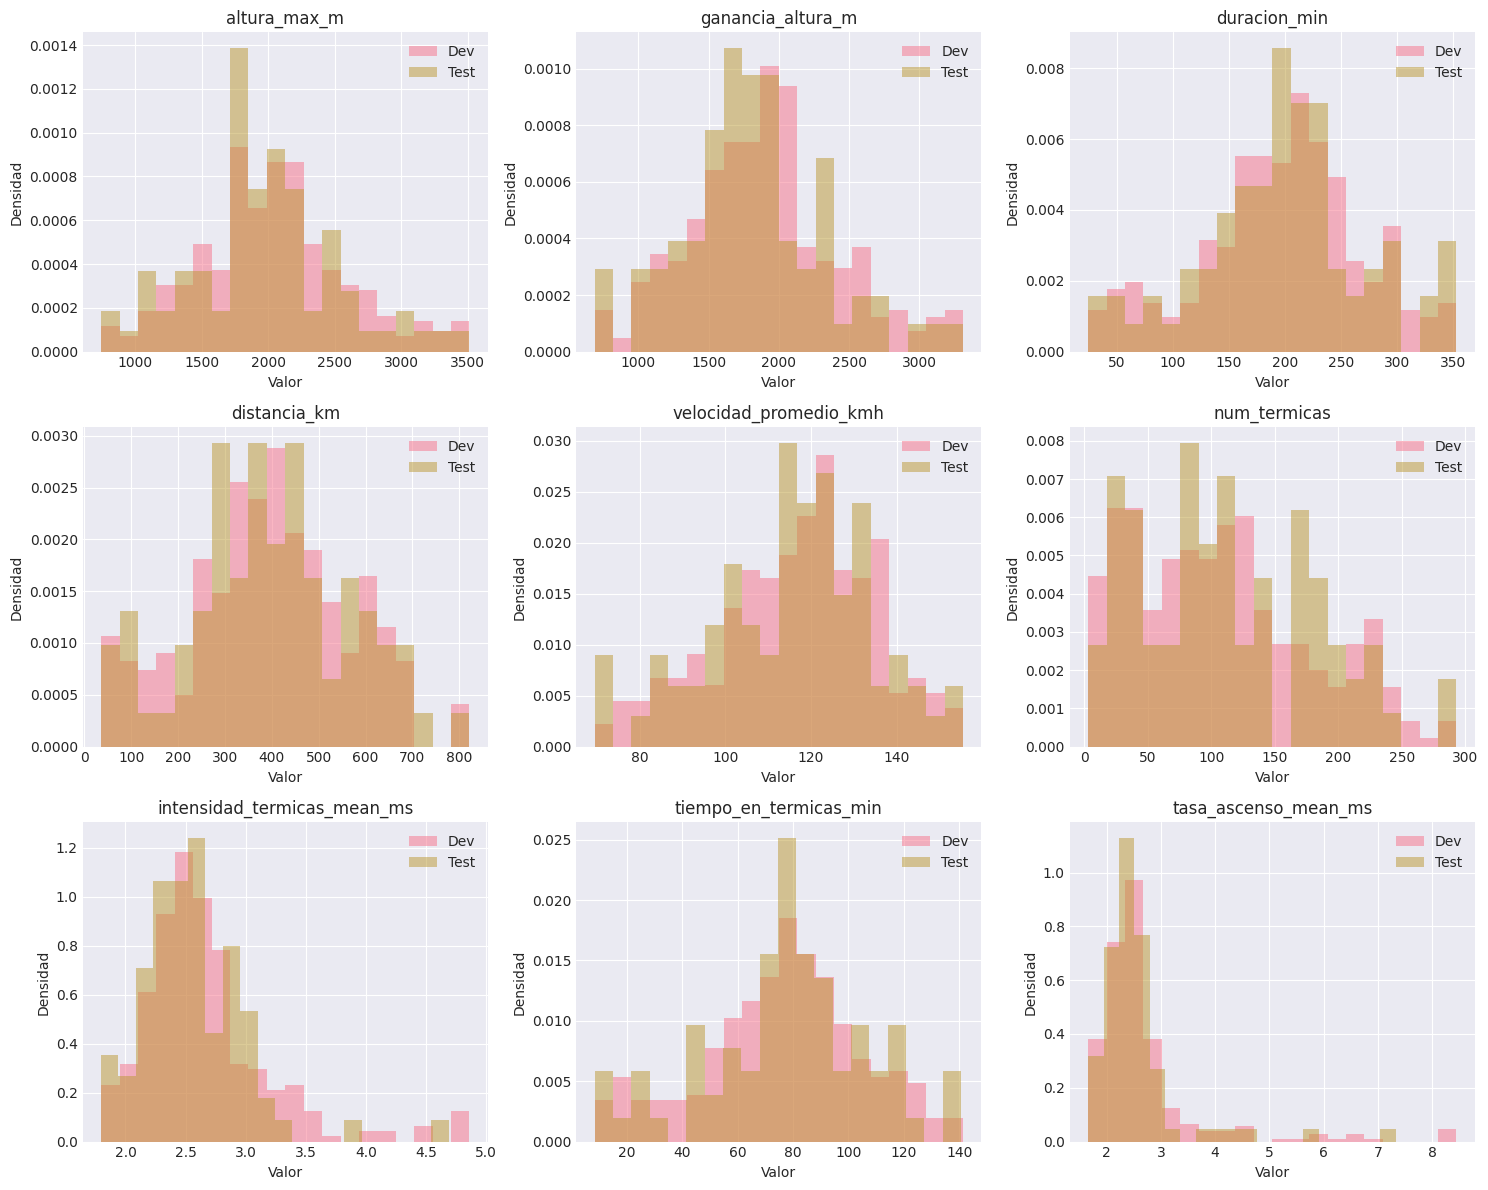


altura_max_m:
  Dev:  mean=2026.55, std=553.10
  Test: mean=1959.57, std=560.70

ganancia_altura_m:
  Dev:  mean=1887.22, std=530.73
  Test: mean=1815.59, std=525.09

duracion_min:
  Dev:  mean=196.88, std=71.82
  Test: mean=199.02, std=73.67

distancia_km:
  Dev:  mean=393.62, std=170.34
  Test: mean=394.92, std=171.80

velocidad_promedio_kmh:
  Dev:  mean=116.53, std=18.34
  Test: mean=115.36, std=18.95

num_termicas:
  Dev:  mean=108.15, std=69.45
  Test: mean=112.28, std=69.93

intensidad_termicas_mean_ms:
  Dev:  mean=2.67, std=0.55
  Test: mean=2.56, std=0.44

tiempo_en_termicas_min:
  Dev:  mean=76.38, std=28.76
  Test: mean=77.31, std=29.28

tasa_ascenso_mean_ms:
  Dev:  mean=2.73, std=1.12
  Test: mean=2.57, std=0.83


In [16]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, target in enumerate(targets_reg):
    ax = axes[i]
    
    # Histogramas
    ax.hist(y_dev[target], bins=20, alpha=0.5, label='Dev', density=True)
    ax.hist(y_test[target], bins=20, alpha=0.5, label='Test', density=True)
    
    ax.set_title(target)
    ax.legend()
    ax.set_xlabel('Valor')
    ax.set_ylabel('Densidad')

plt.tight_layout()
plt.savefig('../data/processed/distribucion_dev_test.png', dpi=300)
plt.show()

# Estadísticas
for target in targets_reg:
    print(f"\n{target}:")
    print(f"  Dev:  mean={y_dev[target].mean():.2f}, std={y_dev[target].std():.2f}")
    print(f"  Test: mean={y_test[target].mean():.2f}, std={y_test[target].std():.2f}")

Las distribuciones de dev y test son similares en media y forma, validando 
el split estratificado. Sin embargo, test muestra ligeramente menor varianza 
en algunos targets (intensidad_termicas: -20%, tasa_ascenso: -26%), 
resultando en menor presencia de outliers.

Esto, combinado con el tamaño pequeño del test set (78 samples), explica el 
gap negativo sistemático (promedio=-0.10). Los scores de CV representan una 
estimación más conservadora y confiable del rendimiento en producción, 
mientras que test scores son ligeramente optimistas.

Rendimiento esperado en datos nuevos: entre CV y Test, más cercano a CV.

## 6. Random Search - Features COMPLETAS

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Archivo pickle para guardar resultados
pkl_file_full = '../data/processed/xgb_full_models.pkl'

# ---------------------------------------------------------------------
# 1) Definimos el espacio de búsqueda (más chico, pero razonable)
# ---------------------------------------------------------------------

param_dist = {
    'max_depth': [2, 3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 10, None],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# ---------------------------------------------------------------------
# Intentar cargar resultados previos
# ---------------------------------------------------------------------
if os.path.exists(pkl_file_full):
    print("="*70)
    print("✓ Cargando resultados previos (Grid/Random Search ya ejecutado)")
    print("="*70)
    
    with open(pkl_file_full, 'rb') as f:
        saved_data = pickle.load(f)
        resultados_xgb_full = saved_data['resultados']
        mejores_modelos_full = saved_data['modelos']
    
    df_xgb_full = pd.DataFrame(resultados_xgb_full)
    
    print(f"\n✓ Cargados {len(resultados_xgb_full)} targets")
    print(f"Gap promedio: {df_xgb_full['Gap'].mean():.4f}")
    print(f"R² promedio Test: {df_xgb_full['Test_R2'].mean():.4f}")
    print("\nSi querés re-entrenar, eliminá el archivo:")
    print(f"  {pkl_file_full}")

else:

    resultados_xgb_full = []
    mejores_modelos_full = {}

    print("RANDOMIZED SEARCH - XGBoost FEATURES COMPLETAS (CPU hist)")

    for target in targets_reg:
        print(f"\n{target}:")
        inicio = time()
        
        # -------------------------------------------------------------
        # 2) Modelo base: usamos 'hist' para que sea MUCHO más rápido
        # -------------------------------------------------------------
        xgb_base = XGBRegressor(
            random_state=42,
            n_jobs=-1,
            tree_method='hist',   # <-- cambio clave
            eval_metric='rmse'    # métrica interna de XGBoost
        )
        
        # -------------------------------------------------------------
        # 3) Randomized Search con CV
        #    - n_iter: cuántas combinaciones probar
        #    - cv=3 para no explotar el tiempo
        # -------------------------------------------------------------
        search = RandomizedSearchCV(
            estimator=xgb_base,
            param_distributions=param_dist,
            n_iter=50,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        
        search.fit(X_dev_full, y_dev[target])
        
        # Mejor modelo
        best_xgb = search.best_estimator_
        mejores_modelos_full[target] = best_xgb
        
        # Predicciones
        y_pred_dev = best_xgb.predict(X_dev_full)
        y_pred_test = best_xgb.predict(X_test_full)
        
        r2_cv = search.best_score_
        r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
        r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
        gap = r2_cv - r2_test
        
        resultados_xgb_full.append({
            'target': target,
            'features': 'full',
            'max_depth': search.best_params_['max_depth'],
            'min_child_weight': search.best_params_['min_child_weight'],
            'learning_rate': search.best_params_['learning_rate'],
            'n_estimators': search.best_params_['n_estimators'],
            'subsample': search.best_params_['subsample'],
            'colsample_bytree': search.best_params_['colsample_bytree'],
            'CV_R2': r2_cv,
            'Dev_R2': r2_dev,
            'Test_R2': max(0, r2_test),
            'Gap': gap
        })
        
        tiempo = time() - inicio
        overfit_signal = " OVERFITTING" if gap > 0.15 else "✓ OK"
        
        print(f"  Mejores params (seleccionados por CV):")
        print(f"    max_depth={search.best_params_['max_depth']}, "
              f"min_child_weight={search.best_params_['min_child_weight']}")
        print(f"    lr={search.best_params_['learning_rate']}, "
              f"n_est={search.best_params_['n_estimators']}")
        print(f"    subsample={search.best_params_['subsample']}, "
              f"colsample={search.best_params_['colsample_bytree']}")
        print(f"  CV={r2_cv:.4f}, Test={max(0, r2_test):.4f}, "
              f"Gap={gap:.4f} {overfit_signal}")
        print(f"  Tiempo: {tiempo:.1f}s")

    df_xgb_full = pd.DataFrame(resultados_xgb_full)

    # GUARDAR con pickle
    with open(pkl_file_full, 'wb') as f:
        pickle.dump({
            'resultados': resultados_xgb_full,
            'modelos': mejores_modelos_full
        }, f)
    
    print(f"Resultados guardados en: {pkl_file_full}")
    print(f"Gap promedio: {df_xgb_full['Gap'].mean():.4f}")
    print(f"R² promedio Test: {df_xgb_full['Test_R2'].mean():.4f}")

# Exportar a CSV como antes
df_xgb_full.to_csv('../data/processed/xgb_full.csv', index=False)


RANDOMIZED SEARCH - XGBoost FEATURES COMPLETAS (CPU hist)

altura_max_m:
Fitting 5 folds for each of 50 candidates, totalling 250 fits


  Mejores params (seleccionados por CV):
    max_depth=10, min_child_weight=3
    lr=0.05, n_est=100
    subsample=0.6, colsample=1.0
  CV=0.6179, Test=0.7164, Gap=-0.0985 ✓ OK
  Tiempo: 30.8s

ganancia_altura_m:
Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Mejores params (seleccionados por CV):
    max_depth=5, min_child_weight=3
    lr=0.05, n_est=200
    subsample=1.0, colsample=1.0
  CV=0.5850, Test=0.6951, Gap=-0.1102 ✓ OK
  Tiempo: 31.0s

duracion_min:
Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Mejores params (seleccionados por CV):
    max_depth=7, min_child_weight=1
    lr=0.05, n_est=150
    subsample=0.8, colsample=1.0
  CV=0.5836, Test=0.6377, Gap=-0.0541 ✓ OK
  Tiempo: 33.2s

distancia_km:
Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Mejores params (seleccionados por CV):
    max_depth=10, min_child_weight=3
    lr=0.05, n_est=100
    subsample=0.6, colsample=1.0
  CV=0.5841, Test=0.7705, Gap=-0.1864 ✓ OK
  Tiempo: 

Test set parece más fácil que la población real, entonces:

CV como métrica conservadora
Test como métrica optimista
Rendimiento real probablemente entre ambos

## 7. Comparación Simple vs Full

In [ ]:
print("COMPARACIÓN: Features Simples vs Completas (XGBoost optimizado)")

for target in targets_reg:
    r2_simple = df_xgb_simple[df_xgb_simple['target']==target]['Test_R2'].values[0]
    r2_full = df_xgb_full[df_xgb_full['target']==target]['Test_R2'].values[0]
    gap_simple = df_xgb_simple[df_xgb_simple['target']==target]['Gap'].values[0]
    gap_full = df_xgb_full[df_xgb_full['target']==target]['Gap'].values[0]
    
    print(f"\n{target}:")
    print(f"  Simple: R²={r2_simple:.4f}, Gap={gap_simple:.4f}")
    print(f"  Full:   R²={r2_full:.4f}, Gap={gap_full:.4f}")
    
    if r2_simple > r2_full:
        print(f"  SIMPLE mejor ({r2_simple - r2_full:+.4f})")
    else:
        print(f"  FULL mejor ({r2_full - r2_simple:+.4f})")

print(f"R² promedio SIMPLE: {df_xgb_simple['Test_R2'].mean():.4f}")
print(f"R² promedio FULL:   {df_xgb_full['Test_R2'].mean():.4f}")
print(f"Gap promedio SIMPLE: {df_xgb_simple['Gap'].mean():.4f}")
print(f"Gap promedio FULL:   {df_xgb_full['Gap'].mean():.4f}")

# Seleccionar mejor configuración
usar_simple = df_xgb_simple['Test_R2'].mean() >= df_xgb_full['Test_R2'].mean()

if usar_simple:
    df_xgb_final = df_xgb_simple
    mejores_modelos_xgb = mejores_modelos_simple
    features_final = 'simple'
else:
    df_xgb_final = df_xgb_full
    mejores_modelos_xgb = mejores_modelos_full
    features_final = 'full'

print(f" CONFIGURACIÓN FINAL: Features {features_final.upper()}")
print(f"  R² promedio: {df_xgb_final['Test_R2'].mean():.4f}")
print(f"  Gap promedio: {df_xgb_final['Gap'].mean():.4f}")


COMPARACIÓN: Features Simples vs Completas (XGBoost optimizado)

altura_max_m:
  Simple: R²=0.7227, Gap=-0.0834
  Full:   R²=0.7164, Gap=-0.0985
  ✓ SIMPLE mejor (+0.0062)

ganancia_altura_m:
  Simple: R²=0.6246, Gap=-0.0150
  Full:   R²=0.6951, Gap=-0.1102
  ✓ FULL mejor (+0.0706)

duracion_min:
  Simple: R²=0.7719, Gap=-0.1785
  Full:   R²=0.6377, Gap=-0.0541
  ✓ SIMPLE mejor (+0.1342)

distancia_km:
  Simple: R²=0.8172, Gap=-0.2125
  Full:   R²=0.7705, Gap=-0.1864
  ✓ SIMPLE mejor (+0.0468)

velocidad_promedio_kmh:
  Simple: R²=0.5051, Gap=-0.2185
  Full:   R²=0.4104, Gap=-0.1440
  ✓ SIMPLE mejor (+0.0947)

num_termicas:
  Simple: R²=0.2588, Gap=-0.1037
  Full:   R²=0.2270, Gap=-0.0865
  ✓ SIMPLE mejor (+0.0318)

intensidad_termicas_mean_ms:
  Simple: R²=0.0000, Gap=0.0112
  Full:   R²=0.0000, Gap=0.0163
  ✓ FULL mejor (+0.0000)

tiempo_en_termicas_min:
  Simple: R²=0.7396, Gap=-0.1501
  Full:   R²=0.7338, Gap=-0.1678
  ✓ SIMPLE mejor (+0.0058)

tasa_ascenso_mean_ms:
  Simple: R²=0.

---
# PARTE 2: Análisis y Comparación

## 8. Análisis de Hiperparámetros Óptimos

In [ ]:
print(f"ANÁLISIS: Hiperparámetros Óptimos (Features {features_final})")

print("\nValores más frecuentes:")
for param in ['max_depth', 'min_child_weight', 'learning_rate', 
              'n_estimators', 'subsample', 'colsample_bytree']:
    moda = df_xgb_final[param].mode()[0]
    mediana = df_xgb_final[param].median()
    print(f"  {param:20s}: moda={moda}, mediana={mediana}")

print("\nDistribución de max_depth:")
print(df_xgb_final['max_depth'].value_counts().sort_index())

print("\nDistribución de learning_rate:")
print(df_xgb_final['learning_rate'].value_counts().sort_index())

print("\nDistribución de min_child_weight:")
print(df_xgb_final['min_child_weight'].value_counts().sort_index())

print("CONCLUSIÓN: CV seleccionó hiperparámetros que evitan overfitting")
print(f"  max_depth típico: {df_xgb_final['max_depth'].median():.0f}")
print(f"  learning_rate típico: {df_xgb_final['learning_rate'].median():.2f}")
print(f"  min_child_weight típico: {df_xgb_final['min_child_weight'].median():.0f}")

ANÁLISIS: Hiperparámetros Óptimos (Features simple)

Valores más frecuentes:
  max_depth           : moda=4, mediana=4.0
  min_child_weight    : moda=1, mediana=1.0
  learning_rate       : moda=0.05, mediana=0.05
  n_estimators        : moda=100, mediana=100.0
  subsample           : moda=0.6, mediana=0.7
  colsample_bytree    : moda=0.8, mediana=0.8

Distribución de max_depth:
max_depth
2    2
3    1
4    3
6    3
Name: count, dtype: int64

Distribución de learning_rate:
learning_rate
0.01    2
0.05    5
0.10    1
0.20    1
Name: count, dtype: int64

Distribución de min_child_weight:
min_child_weight
1     5
3     2
10    2
Name: count, dtype: int64

CONCLUSIÓN: CV seleccionó hiperparámetros que evitan overfitting
  max_depth típico: 4
  learning_rate típico: 0.05
  min_child_weight típico: 1


## 9. Feature Importance

Analizando feature importance para: distancia_km

Top 10 features más importantes:
  temp_2m_avg                   : 0.1662
  skin_temp_avg                 : 0.0996
  club_0                        : 0.0824
  club_2                        : 0.0803
  cape_avg                      : 0.0765
  boundary_layer_height_avg     : 0.0737
  wind_v_avg                    : 0.0613
  hora_despegue_ajustada        : 0.0579
  wind_u_avg                    : 0.0574
  solar_rad_avg                 : 0.0555


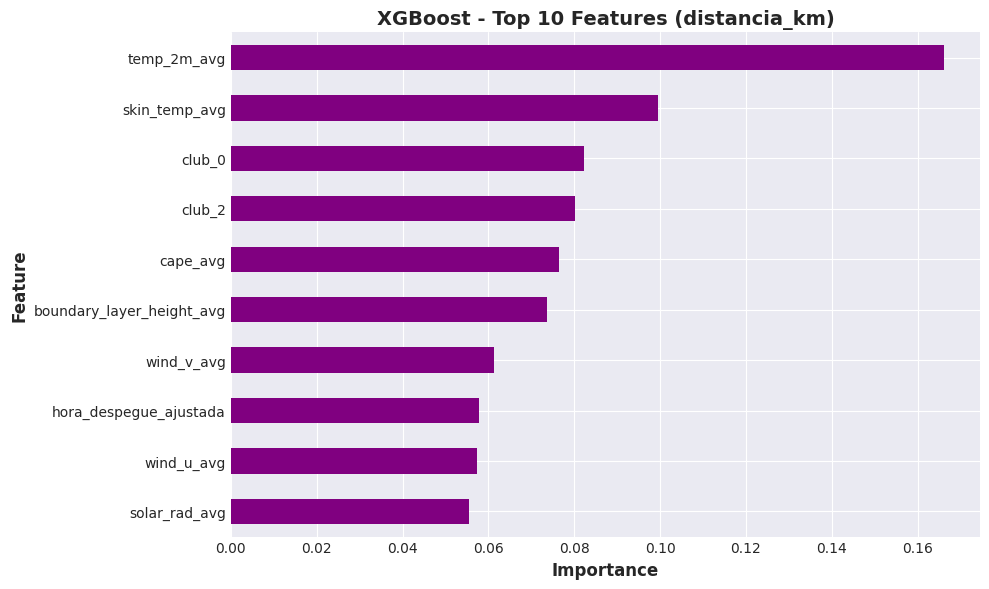

In [38]:
# Mejor target
mejor_target = df_xgb_final.nlargest(1, 'Test_R2').iloc[0]['target']
print(f"Analizando feature importance para: {mejor_target}")

xgb_model = mejores_modelos_xgb[mejor_target]

if features_final == 'simple':
    feature_names = X_dev_simple.columns
else:
    feature_names = X_dev_full.columns

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 features más importantes:")
for _, row in importances.head(10).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
importances.head(10).plot(x='feature', y='importance', kind='barh', 
                          ax=ax, legend=False, color='purple')
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title(f'XGBoost - Top 10 Features ({mejor_target})', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../data/processed/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Comparación Final: Baseline vs RF vs XGBoost

In [ ]:
# Cargar resultados anteriores
df_baseline = pd.read_csv('../data/processed/baseline_completo.csv')
df_rf = pd.read_csv('../data/processed/rf_tuning.csv')

# Mejor baseline por target
df_baseline_best = df_baseline.loc[
    df_baseline.groupby('target')['Test_R2'].idxmax()
]

print("COMPARACIÓN FINAL: Baseline vs Random Forest vs XGBoost")

comparacion_final = []

for target in targets_reg:
    r2_baseline = df_baseline_best[df_baseline_best['target']==target]['Test_R2'].values[0]
    r2_rf = df_rf[df_rf['target']==target]['Test_R2'].values[0]
    r2_xgb = df_xgb_final[df_xgb_final['target']==target]['Test_R2'].values[0]
    
    mejor = max(r2_baseline, r2_rf, r2_xgb)
    
    if mejor == r2_baseline:
        ganador = 'Baseline'
    elif mejor == r2_rf:
        ganador = 'RandomForest'
    else:
        ganador = 'XGBoost'
    
    comparacion_final.append({
        'target': target,
        'Baseline': r2_baseline,
        'RandomForest': r2_rf,
        'XGBoost': r2_xgb,
        'Ganador': ganador,
        'Mejor_R2': mejor
    })
    
    print(f"\n{target}:")
    print(f"  Baseline:     R² = {r2_baseline:.4f}")
    print(f"  RandomForest: R² = {r2_rf:.4f}")
    print(f"  XGBoost:      R² = {r2_xgb:.4f}")
    print(f"   Ganador: {ganador}")

df_comparacion = pd.DataFrame(comparacion_final)

print("RESUMEN POR MODELO:")
print(f"  Baseline:     {df_comparacion['Baseline'].mean():.4f} promedio")
print(f"  RandomForest: {df_comparacion['RandomForest'].mean():.4f} promedio")
print(f"  XGBoost:      {df_comparacion['XGBoost'].mean():.4f} promedio")

print("\n  Ganadores por target:")
print(df_comparacion['Ganador'].value_counts())


COMPARACIÓN FINAL: Baseline vs Random Forest vs XGBoost

altura_max_m:
  Baseline:     R² = 0.6070
  RandomForest: R² = 0.6906
  XGBoost:      R² = 0.7227
  ✓ Ganador: XGBoost

ganancia_altura_m:
  Baseline:     R² = 0.5506
  RandomForest: R² = 0.6683
  XGBoost:      R² = 0.6246
  ✓ Ganador: RandomForest

duracion_min:
  Baseline:     R² = 0.6985
  RandomForest: R² = 0.7370
  XGBoost:      R² = 0.7719
  ✓ Ganador: XGBoost

distancia_km:
  Baseline:     R² = 0.6567
  RandomForest: R² = 0.7560
  XGBoost:      R² = 0.8172
  ✓ Ganador: XGBoost

velocidad_promedio_kmh:
  Baseline:     R² = 0.4824
  RandomForest: R² = 0.4907
  XGBoost:      R² = 0.5051
  ✓ Ganador: XGBoost

num_termicas:
  Baseline:     R² = 0.1697
  RandomForest: R² = 0.2638
  XGBoost:      R² = 0.2588
  ✓ Ganador: RandomForest

intensidad_termicas_mean_ms:
  Baseline:     R² = 0.0000
  RandomForest: R² = 0.0000
  XGBoost:      R² = 0.0000
  ✓ Ganador: Baseline

tiempo_en_termicas_min:
  Baseline:     R² = 0.7144
  RandomFo

## 11. Visualizaciones

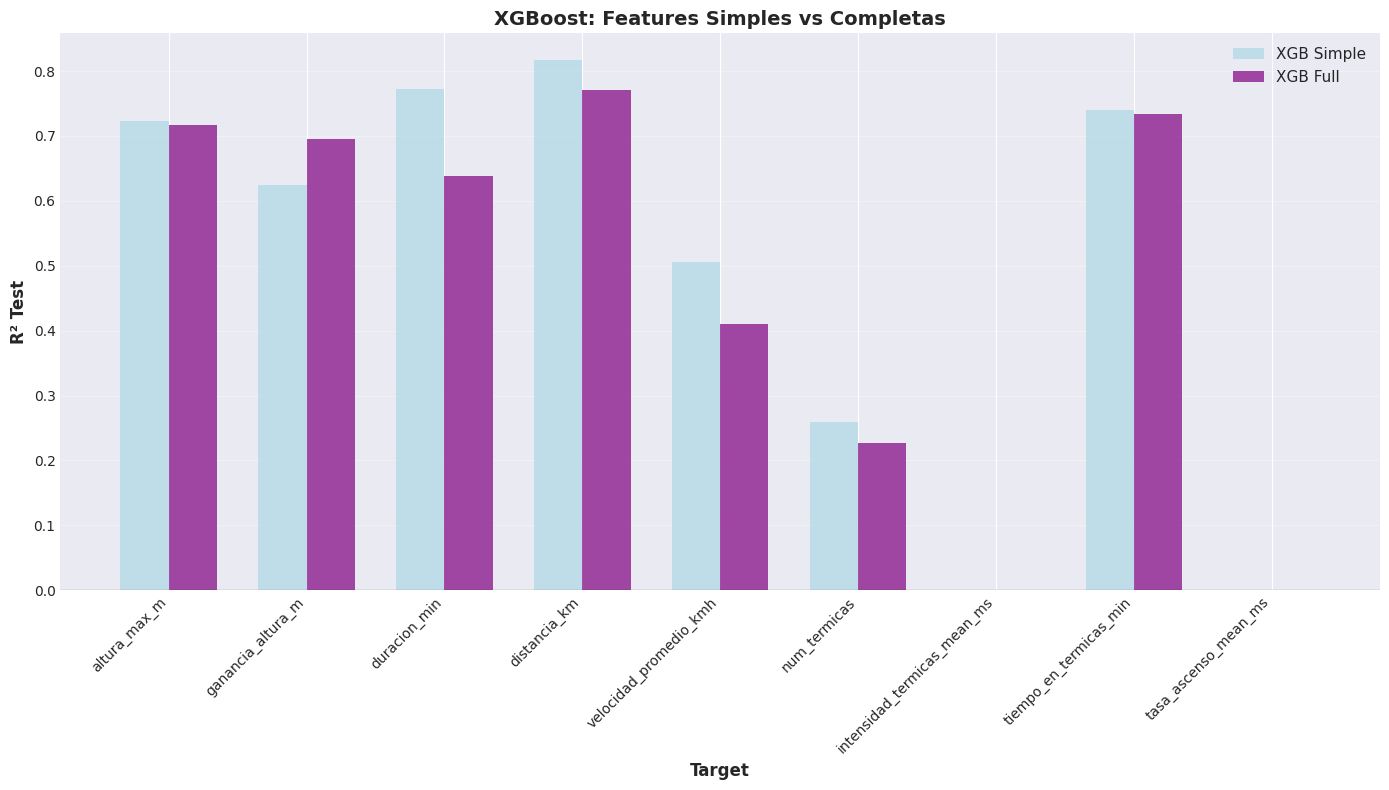

In [40]:
# Gráfico 1: Simple vs Full
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(targets_reg))
width = 0.35

ax.bar(x - width/2, df_xgb_simple['Test_R2'], width, 
       label='XGB Simple', alpha=0.7, color='lightblue')
ax.bar(x + width/2, df_xgb_full['Test_R2'], width, 
       label='XGB Full', alpha=0.7, color='purple')

ax.set_xlabel('Target', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Test', fontsize=12, fontweight='bold')
ax.set_title('XGBoost: Features Simples vs Completas', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/xgb_simple_vs_full.png', dpi=300, bbox_inches='tight')
plt.show()

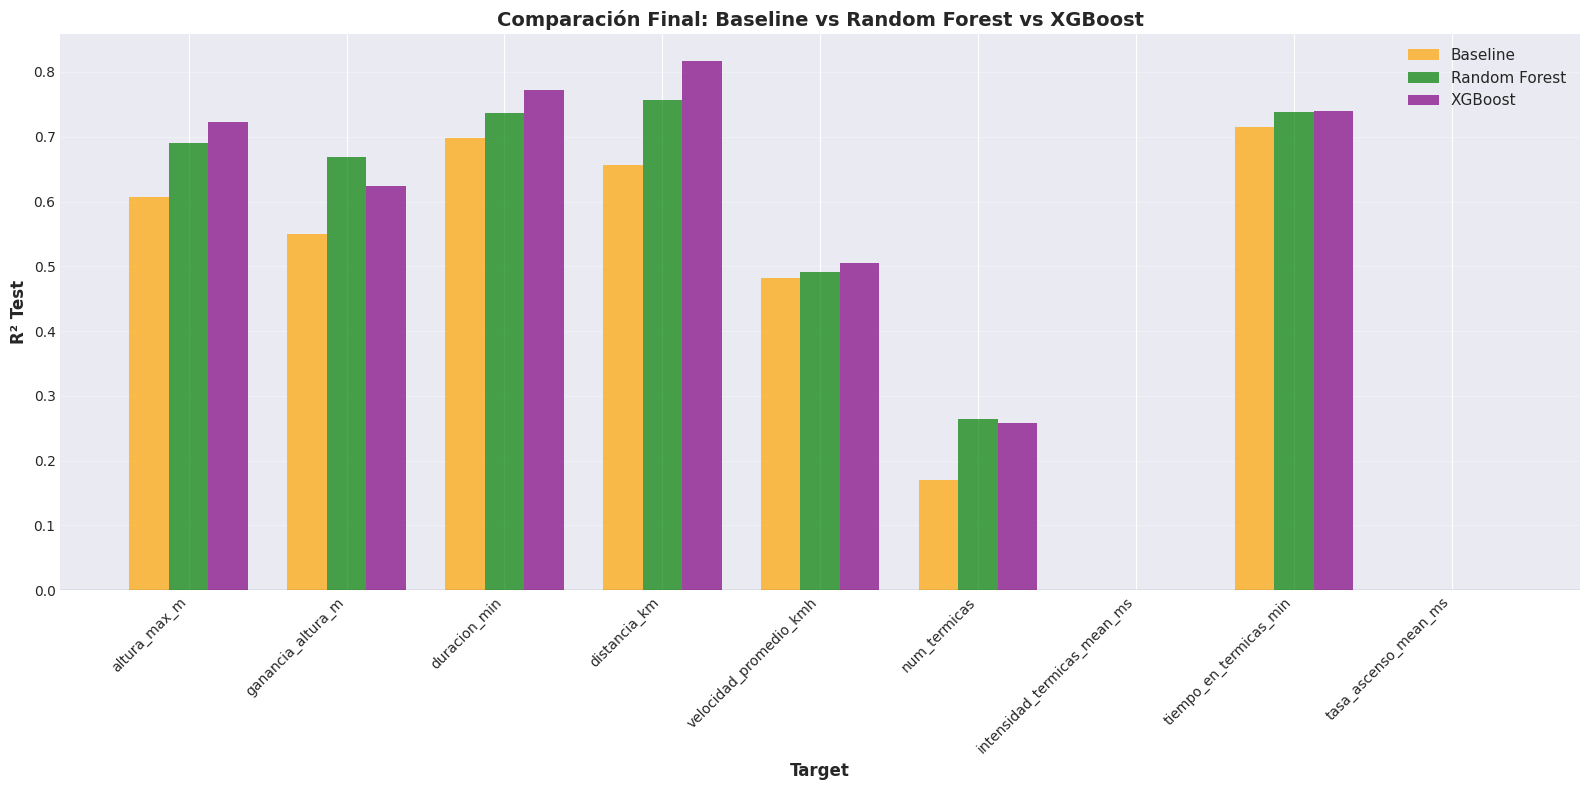

In [41]:
# Gráfico 2: Comparación Final
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(targets_reg))
width = 0.25

ax.bar(x - width, df_comparacion['Baseline'], width, 
       label='Baseline', alpha=0.7, color='orange')
ax.bar(x, df_comparacion['RandomForest'], width, 
       label='Random Forest', alpha=0.7, color='green')
ax.bar(x + width, df_comparacion['XGBoost'], width, 
       label='XGBoost', alpha=0.7, color='purple')

ax.set_xlabel('Target', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Test', fontsize=12, fontweight='bold')
ax.set_title('Comparación Final: Baseline vs Random Forest vs XGBoost', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/comparacion_final_todos.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Conclusiones Finales

In [ ]:
mejor_modelo = df_comparacion[['Baseline', 'RandomForest', 'XGBoost']].mean().idxmax()

print("RESUMEN FINAL - PROYECTO ML COMPLETO")

print("\n1. PERFORMANCE PROMEDIO (R² Test):")
print(f"   Baseline:     {df_comparacion['Baseline'].mean():.4f}")
print(f"   RandomForest: {df_comparacion['RandomForest'].mean():.4f}")
print(f"   XGBoost:      {df_comparacion['XGBoost'].mean():.4f}")
print(f"\n    GANADOR: {mejor_modelo}")

print("\n2. TOP 5 TARGETS:")
top5 = df_comparacion.nlargest(5, 'Mejor_R2')
for i, row in enumerate(top5.itertuples(), 1):
    print(f"   {i}. {row.target:30s}: R² = {row.Mejor_R2:.4f} ({row.Ganador})")

print("\n3. GANADORES POR TARGET:")
for modelo, cuenta in df_comparacion['Ganador'].value_counts().items():
    print(f"   {modelo:15s}: {cuenta}/9 targets")

print(f"\n4. CONFIGURACIÓN XGBOOST ÓPTIMA:")
print(f"   Features: {features_final}")
print(f"   max_depth típico: {df_xgb_final['max_depth'].median():.0f}")
print(f"   learning_rate típico: {df_xgb_final['learning_rate'].median():.2f}")
print(f"   min_child_weight típico: {df_xgb_final['min_child_weight'].median():.0f}")
print(f"   Gap promedio: {df_xgb_final['Gap'].mean():.4f}")

print("\n5. RECOMENDACIÓN FINAL:")

if mejor_modelo == 'XGBoost':
    print(f"\n USAR: XGBoost con features {features_final}")
    print("\nMotivos:")
    print("  • Mejor R² promedio")
    print("  • Grid Search + CV evitó overfitting automáticamente")
    print("  • Captura interacciones no lineales")
elif mejor_modelo == 'RandomForest':
    print("\n USAR: Random Forest con features simples")
    print("\nMotivos:")
    print("  • Mejor R² promedio")
    print("  • Más robusto con datasets pequeños")
    print("  • Evita curse of dimensionality")
else:
    print("\n USAR: Baseline (modelos lineales)")
    print("\nMotivos:")
    print("  • Más interpretable")
    print("  • Menor riesgo de overfitting")
    print("  • Más simple y eficiente")

RESUMEN FINAL - PROYECTO ML COMPLETO

1. PERFORMANCE PROMEDIO (R² Test):
   Baseline:     0.4310
   RandomForest: 0.4828
   XGBoost:      0.4933

   ✓ GANADOR: XGBoost

2. TOP 5 TARGETS:
   1. distancia_km                  : R² = 0.8172 (XGBoost)
   2. duracion_min                  : R² = 0.7719 (XGBoost)
   3. tiempo_en_termicas_min        : R² = 0.7396 (XGBoost)
   4. altura_max_m                  : R² = 0.7227 (XGBoost)
   5. ganancia_altura_m             : R² = 0.6683 (RandomForest)

3. GANADORES POR TARGET:
   XGBoost        : 5/9 targets
   RandomForest   : 2/9 targets
   Baseline       : 2/9 targets

4. CONFIGURACIÓN XGBOOST ÓPTIMA:
   Features: simple
   max_depth típico: 4
   learning_rate típico: 0.05
   min_child_weight típico: 1
   Gap promedio: -0.0988

5. RECOMENDACIÓN FINAL:

✓ USAR: XGBoost con features simple

Motivos:
  • Mejor R² promedio
  • Grid Search + CV evitó overfitting automáticamente
  • Captura interacciones no lineales

✓ PROYECTO ML FINALIZADO


## 13. Guardar Resultados

In [ ]:
# Guardar DataFrames
df_xgb_simple.to_csv('../data/processed/xgb_simple.csv', index=False)
df_xgb_full.to_csv('../data/processed/xgb_full.csv', index=False)
df_xgb_final.to_csv('../data/processed/xgb_final.csv', index=False)
df_comparacion.to_csv('../data/processed/comparacion_final.csv', index=False)

print("ARCHIVOS GUARDADOS")
print("  - xgb_simple.csv")
print("  - xgb_full.csv")
print("  - xgb_final.csv")
print("  - comparacion_final.csv")
print("  - xgb_feature_importance.png")
print("  - xgb_simple_vs_full.png")
print("  - comparacion_final_todos.png")


ARCHIVOS GUARDADOS
  - xgb_simple.csv
  - xgb_full.csv
  - xgb_final.csv
  - comparacion_final.csv
  - xgb_feature_importance.png
  - xgb_simple_vs_full.png
  - comparacion_final_todos.png
